## Network with multi-period battery dispatch

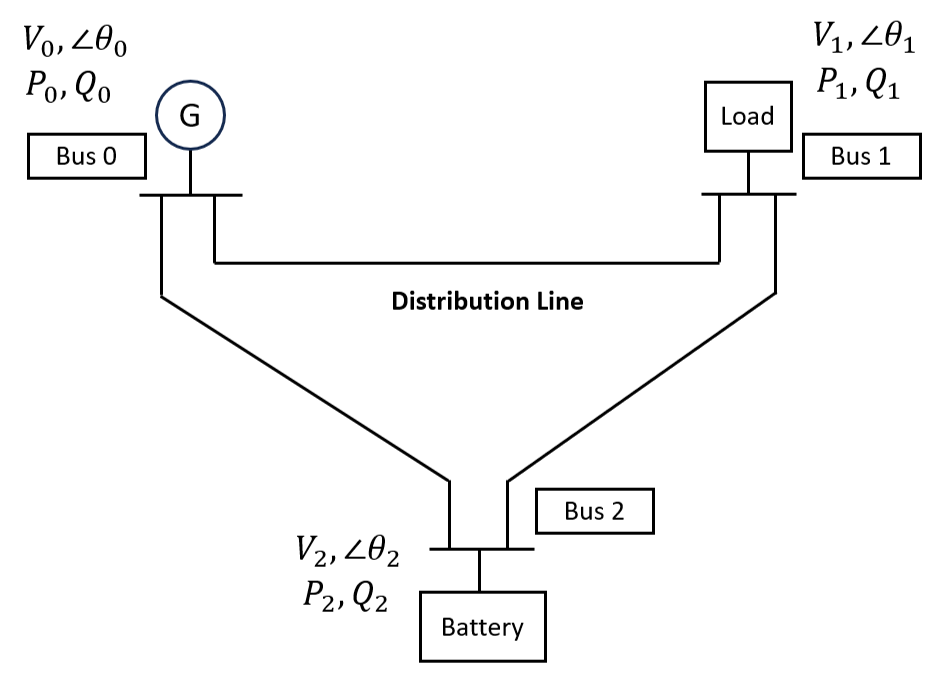

In [1]:
pip install pypsa


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U pypsa


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Build Network Model

In [3]:
import numpy as np
import pandas as pd
import pypsa

n = pypsa.Network()

# 24 hourly snapshots
snapshots = pd.date_range("2025-01-01 00:00", periods=24, freq="h")
n.set_snapshots(snapshots)

# Carrier
n.add("Carrier", "AC")

# 8 buses
for i in range(8):
    n.add("Bus", f"Bus {i}", v_nom=400.0, carrier="AC")

# Lines: ring + two diagonals
line_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (4, 5), (5, 6), (6, 7), (7, 0),  # ring
    (2, 6), (3, 7)                   # diagonals
]
for idx, (bus0, bus1) in enumerate(line_connections):
    n.add("Line", f"Line {idx}",
          bus0=f"Bus {bus0}",
          bus1=f"Bus {bus1}",
          x=0.1, r=0.01, s_nom=100, carrier="AC")

# Generators (fixed capacities, committable)
gen_buses = [0, 1, 2, 3, 4, 5]
gen_costs = [10, 12, 18, 13, 20, 15]
gen_pom = [500,400,410,440,600,485]

for i, (bus, cost, pow) in enumerate(zip(gen_buses, gen_costs,gen_pom)):
    n.add("Generator", f"Gen {i}",
          bus=f"Bus {bus}",
          p_nom=pow,
          p_min_pu=0,
          p_max_pu=1,
          sign=1,
          marginal_cost=cost,
          control="PV")

# Loads
load_data = {
    "Load A": ("Bus 6", 60),
    "Load B": ("Bus 7", 70),
    "Load C": ("Bus 3", 300)
}
for name, (bus, p_val) in load_data.items():
    n.add("Load", name, bus=bus, p_set=p_val)

# Storage units
storage_data = {
    "Storage 1": "Bus 5",
    "Storage 2": "Bus 6",
    "Storage 3": "Bus 7"
}

# Add batteries
for name, bus in storage_data.items():
    n.add("StorageUnit", name,
          bus=bus,
          p_nom=400,
          efficiency_store=0.9,
          efficiency_dispatch=0.9,
          max_hours=2,                    # 50 MW * 2 h = 100 MWh capacity
          state_of_charge_initial=800,    # 100% of capacity
          marginal_cost=0.01,                # cost on discharge
          marginal_cost_quadratic=0.5,       # convex QP term (HiGHS supports)
          capital_cost=0)


#### Add **User A, B ,C** to the existing Network 

In [4]:
# ---------------------------
# Add OPF-P2P users
# ---------------------------

# --- User A: PV (producer) at Bus 1 ---
# If you later add a PV time series, set p_max_pu to that series.
if "UserA_PV" not in n.generators.index:
    n.add(
        "Generator", "UserA_PV",
        bus="Bus 1",
        carrier="solar",
        p_nom=100.0,          # MW (adjust as you like)
        p_min_pu=0.0,
        p_max_pu=1.0,
        marginal_cost=0.5,   
        marginal_cost_quadratic=1.1,
        control="PQ"
    )

# --- User B: Battery (can charge/discharge) at Bus 5 ---
if "UserB_Battery" not in n.storage_units.index:
    n.add(
        "StorageUnit", "UserB_Battery",
        bus="Bus 5",
        carrier="battery",
        p_nom=80.0,           # MW charge/discharge limit (adjust)
        max_hours=10,        # => 800 MWh capacity
        efficiency_store=0.95,
        efficiency_dispatch=0.95,
        standing_loss=0.001,      # per snapshot
        marginal_cost=0.01,       # discharge cost (£/MWh or your unit)
        marginal_cost_quadratic=0.2,
        capital_cost=0.0
    )

# --- User C: Load (consumer) at Bus 3 ---
# If you want it on another bus, change bus="Bus 3".
if "UserC_Load" not in n.loads.index:
    n.add(
        "Load", "UserC_Load",
        bus="Bus 3",
        p_set=50.0            # MW average load (or a time series)
    )




In [5]:
# Solve (QP with HiGHS)

res = n.optimize()

Index(['UserA_PV'], dtype='object', name='name')
Index(['UserB_Battery'], dtype='object', name='name')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 696 primals, 1752 duals
Objective: 1.32e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
QP   linopy-problem-lghazp0i has 1752 rows; 696 cols; 2948 matrix nonzeros; 696 Hessian nonzeros
Coefficient ranges:
  Matrix [6e-02, 1e+00]
  Cost   [1e-02, 2e+01]
  Bound  [0e+00, 0e+00]
  RHS    [6e+01, 8e+02]
  Iteration        Objective     NullspaceDim
          0        340126.38                0      0.01s
        100        281252.88                7      0.01s
        400         220508.4               35      0.02s
        500        198337.44               46      0.03s
        600        176286.35               60      0.03s
        800        141458.14               89      0.05s
        900        132359.04               96      0.05s
        902        132359.04               96      0.05s
Model name          : linopy-problem-lghazp0i
Model status        : Optimal
Simplex   iterations: 315
QP ASM    iterations: 902
Objective value     :  1.3235748952e+05
P-D objective error :  1.1

#### Display User Accounting Ledger

In [6]:
# 1) Snapshot weighting (usually 1 h per snapshot)
w = n.snapshot_weightings["objective"].reindex(n.snapshots)

# 2) Nodal prices (LMPs). If not present, fill with NaN (or set a fallback).
try:
    lmp = n.buses_t.marginal_price.copy()
except Exception:
    lmp = pd.DataFrame(np.nan, index=n.snapshots, columns=n.buses.index)

def lmp_at(bus_name: str) -> pd.Series:
    return lmp[bus_name] if bus_name in lmp.columns else pd.Series(np.nan, index=n.snapshots)

# 3) Pull user time series
ua_name = "UserA_PV"
ub_name = "UserB_Battery"
uc_name = "UserC_Load"

ua_bus = n.generators.at[ua_name, "bus"]
ub_bus = n.storage_units.at[ub_name, "bus"]
uc_bus = n.loads.at[uc_name, "bus"]

ua_p = n.generators_t.p[ua_name]              # MW (>=0)
ub_p = n.storage_units_t.p[ub_name]           # MW (+discharge, -charge)
uc_p = n.loads_t.p_set.get(uc_name, pd.Series(0.0, index=n.snapshots))  # MW

# 4) Energy per snapshot (MWh)
ua_e   = ua_p * w
ub_sell = ub_p.clip(lower=0.0) * w
ub_buy  = (-ub_p.clip(upper=0.0)) * w
uc_e   = uc_p * w

# 5) Prices per snapshot
price_A = lmp_at(ua_bus)
price_B = lmp_at(ub_bus)
price_C = lmp_at(uc_bus)

# 6) COSTS
# User A (Generator): linear may be time-varying; quadratic usually scalar
def gen_mc_series(gen_name: str) -> pd.Series:
    if "marginal_cost" in n.generators_t and gen_name in n.generators_t.marginal_cost:
        return n.generators_t.marginal_cost[gen_name].reindex(n.snapshots)
    else:
        return pd.Series(n.generators.at[gen_name, "marginal_cost"], index=n.snapshots)

ua_mc_ts  = gen_mc_series(ua_name)  # £/MWh
ua_mc2    = float(n.generators.get("marginal_cost_quadratic",
                                   pd.Series(0.0, index=n.generators.index)).get(ua_name, 0.0))

# Correct weighting: w * (c * p + c2 * p^2)
ua_cost_lin_ts  = w * ua_mc_ts * ua_p
ua_cost_quad_ts = w * ua_mc2 * (ua_p ** 2)
ua_cost_total_ts = ua_cost_lin_ts + ua_cost_quad_ts

# User B (StorageUnit): cost only on discharge (p>0)
def su_mc_series(su_name: str) -> pd.Series:
    # if you ever set n.storage_units_t.marginal_cost, this will pick it up
    if "marginal_cost" in n.storage_units_t and su_name in n.storage_units_t.marginal_cost:
        return n.storage_units_t.marginal_cost[su_name].reindex(n.snapshots)
    else:
        return pd.Series(n.storage_units.at[su_name, "marginal_cost"], index=n.snapshots)

ub_mc_ts = su_mc_series(ub_name)
ub_mc2   = float(n.storage_units.get("marginal_cost_quadratic",
                                     pd.Series(0.0, index=n.storage_units.index)).get(ub_name, 0.0))
ub_p_pos = ub_p.clip(lower=0.0)

ub_cost_lin_ts  = w * ub_mc_ts * ub_p_pos
ub_cost_quad_ts = w * ub_mc2 * (ub_p_pos ** 2)
ub_cost_total_ts = ub_cost_lin_ts + ub_cost_quad_ts

# 7) Cashflows per snapshot (positive = revenue to user; negative = payment by user)
ua_revenue_ts = price_A * ua_e
ub_cash_ts    = price_B * ub_sell - price_B * ub_buy - ub_cost_total_ts
uc_cash_ts    = - price_C * uc_e

# Net for User A (revenue minus own costs)
ua_cash_net_ts = ua_revenue_ts - ua_cost_total_ts

# 8) Assemble per-snapshot ledger
ledger = pd.DataFrame({
    # Energies
    "UserA_energy_MWh": ua_e,
    "UserB_discharge_MWh": ub_sell,
    "UserB_charge_MWh": ub_buy,
    "UserC_energy_MWh": uc_e,

    # Prices
    "Price_UserA_bus": price_A,
    "Price_UserB_bus": price_B,
    "Price_UserC_bus": price_C,

    # User A costs (gen)
    "UserA_cost_lin": ua_cost_lin_ts,
    "UserA_cost_quad": ua_cost_quad_ts,

    # User B costs (battery discharge only)
    "UserB_cost_lin": ub_cost_lin_ts,
    "UserB_cost_quad": ub_cost_quad_ts,

    # Cashflows
    "UserA_revenue": ua_revenue_ts,
    "UserA_cashflow_net": ua_cash_net_ts,     # revenue - own costs
    "UserB_cashflow": ub_cash_ts,
    "UserC_cashflow": uc_cash_ts
}, index=n.snapshots)

# 9) Totals (useful for settlement)
totals = pd.Series({
    # Energy
    "UserA_energy_MWh": ua_e.sum(),
    "UserB_discharge_MWh": ub_sell.sum(),
    "UserB_charge_MWh": ub_buy.sum(),
    "UserC_energy_MWh": uc_e.sum(),

    # User A costs & revenues
    "UserA_cost_lin_total": ua_cost_lin_ts.sum(),
    "UserA_cost_quad_total": ua_cost_quad_ts.sum(),
    "UserA_revenue_total": ua_revenue_ts.sum(),
    "UserA_net_cash_total": ua_cash_net_ts.sum(),

    # User B costs & net cash
    "UserB_cost_lin_total": ub_cost_lin_ts.sum(),
    "UserB_cost_quad_total": ub_cost_quad_ts.sum(),
    "UserB_cashflow_total": ub_cash_ts.sum(),   # >0 net revenue, <0 net payment

    # User C payment (positive number paid)
    "UserC_payment_total": (-uc_cash_ts).sum()
})

print("\n=== OPF-P2P per-snapshot ledger (head) ===")
print(ledger.head())
print("\n=== OPF-P2P settlement totals ===")
print(totals)

# 10) Export
ledger.to_csv("opf_p2p_ledger_timeseries.csv", index=True)
totals.to_csv("opf_p2p_ledger_totals.csv", header=False)
print("\nSaved:")
print(" - opf_p2p_ledger_timeseries.csv")
print(" - opf_p2p_ledger_totals.csv")


=== OPF-P2P per-snapshot ledger (head) ===
                     UserA_energy_MWh  UserB_discharge_MWh  UserB_charge_MWh  \
snapshot                                                                       
2025-01-01 00:00:00          4.863645         1.012523e-14     -0.000000e+00   
2025-01-01 01:00:00          4.863645         0.000000e+00      1.011511e-14   
2025-01-01 02:00:00          4.863645         0.000000e+00     -0.000000e+00   
2025-01-01 03:00:00          4.863645         8.794672e-14     -0.000000e+00   
2025-01-01 04:00:00          4.863645         0.000000e+00      1.008479e-14   

                     UserC_energy_MWh  Price_UserA_bus  Price_UserB_bus  \
snapshot                                                                  
2025-01-01 00:00:00               0.0         11.20002        13.000028   
2025-01-01 01:00:00               0.0         11.20002        13.000028   
2025-01-01 02:00:00               0.0         11.20002        13.000028   
2025-01-01 03:00:00 

### Display the output - Generator and Battery

In [7]:
# ---------------------------
# Results (with small-negative clipping for readability)
# ---------------------------
def clip_small(df, tol=1e-6):
    out = df.copy()
    out[(out.abs() < tol)] = 0.0
    return out

print("\n=== Generator Active Power Outputs (MW) ===")
pg = clip_small(n.generators_t.p)
print(pg)

print("\n=== Storage Power (MW, +discharge, -charge) ===")
ps = clip_small(n.storage_units_t.p)
print(ps)

print("\n=== Storage State of Charge (MWh) ===")
print(n.storage_units_t.state_of_charge)


# ---------------------------
# User-focused outputs
# ---------------------------
ua, ub, uc = "UserA_PV", "UserB_Battery", "UserC_Load"

def clip_small_any(x, tol=1e-6):
    # works for Series or DataFrame
    if isinstance(x, pd.Series):
        out = x.copy()
        out[(out.abs() < tol)] = 0.0
        return out
    else:
        out = x.copy()
        out[(out.abs() < tol)] = 0.0
        return out

# Snapshot weighting (usually 1h)
w = n.snapshot_weightings["objective"].reindex(n.snapshots)

# --- User A (PV) ---
print("\n=== User A (PV) Output (MW) ===")
ua_p = n.generators_t.p[ua]
print(clip_small_any(ua_p))

ua_energy = (ua_p * w).sum()  # MWh over the horizon
print(f"User A total energy exported: {ua_energy:.3f} MWh")

# --- User B (Battery) ---
print("\n=== User B (Battery) Power (MW, +discharge, -charge) ===")
ub_p = n.storage_units_t.p[ub]
print(clip_small_any(ub_p))

# SOC (MWh) + SOC%
print("\n=== User B (Battery) State of Charge (MWh and %) ===")
ub_soc = n.storage_units_t.state_of_charge[ub]

# capacity (MWh)
if "state_of_charge_nom" in n.storage_units.columns:
    ub_cap = float(n.storage_units.at[ub, "state_of_charge_nom"])
else:
    ub_cap = float(n.storage_units.at[ub, "p_nom"] * n.storage_units.at[ub, "max_hours"])

print(ub_soc.rename("UserB_SOC_MWh"))
print((ub_soc / ub_cap * 100.0).rename("UserB_SOC_%"))

ub_discharge_mwh = (ub_p.clip(lower=0.0) * w).sum()
ub_charge_mwh    = (-ub_p.clip(upper=0.0) * w).sum()
print(f"User B discharged energy: {ub_discharge_mwh:.3f} MWh")
print(f"User B charged energy:    {ub_charge_mwh:.3f} MWh")

# --- User C (Load) ---
print("\n=== User C (Load) Demand (MW) ===")
# Prefer actual supplied load if available; otherwise p_set
if hasattr(n.loads_t, "p") and uc in n.loads_t.p.columns:
    uc_p = n.loads_t.p[uc]
else:
    uc_p = n.loads_t.p_set[uc]
print(clip_small_any(uc_p))

uc_energy = (uc_p * w).sum()
print(f"User C total energy consumed: {uc_energy:.3f} MWh")




=== Generator Active Power Outputs (MW) ===
name                      Gen 0  Gen 1  Gen 2       Gen 3  Gen 4  Gen 5  \
snapshot                                                                  
2025-01-01 00:00:00  145.800144    0.0    0.0  289.761198    0.0    0.0   
2025-01-01 01:00:00  145.800127    0.0    0.0  289.761477    0.0    0.0   
2025-01-01 02:00:00  145.800109    0.0    0.0  289.761751    0.0    0.0   
2025-01-01 03:00:00  145.800093    0.0    0.0  289.762020    0.0    0.0   
2025-01-01 04:00:00  145.800076    0.0    0.0  289.762283    0.0    0.0   
2025-01-01 05:00:00  145.800060    0.0    0.0  289.762542    0.0    0.0   
2025-01-01 06:00:00  145.800044    0.0    0.0  289.762795    0.0    0.0   
2025-01-01 07:00:00  145.800029    0.0    0.0  289.763043    0.0    0.0   
2025-01-01 08:00:00  145.800014    0.0    0.0  289.763285    0.0    0.0   
2025-01-01 09:00:00  145.799999    0.0    0.0  289.763523    0.0    0.0   
2025-01-01 10:00:00  145.799985    0.0    0.0  289.7637

### Plot the output - Generator and Battery

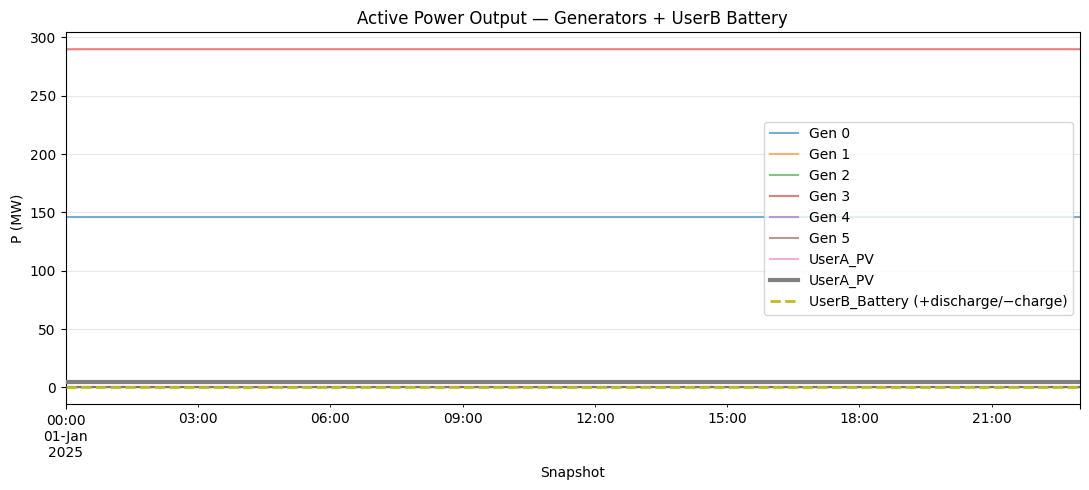

In [8]:
import matplotlib.pyplot as plt

ua, ub = "UserA_PV", "UserB_Battery"
pg_to_plot = pg[[c for c in pg.columns if not c.startswith("_SUinj_")]]

fig, ax = plt.subplots(figsize=(11, 5))
pg_to_plot.plot(ax=ax, alpha=0.6, legend=False)  # no legend for the many base lines

# Emphasize User A + overlay User B
if ua in n.generators_t.p.columns:
    n.generators_t.p[ua].plot(ax=ax, linewidth=3, label="UserA_PV", zorder=5)
if ub in n.storage_units_t.p.columns:
    n.storage_units_t.p[ub].plot(ax=ax, linewidth=2, linestyle="--",
                                 label="UserB_Battery (+discharge/−charge)", zorder=4)

ax.axhline(0, linestyle=":", linewidth=1, color="gray")
ax.set_title("Active Power Output — Generators + UserB Battery")
ax.set_xlabel("Snapshot"); ax.set_ylabel("P (MW)")
ax.grid(True, which="both", axis="y", alpha=0.3)

ax.legend(loc="center right", frameon=True)  # ← mid-right
plt.tight_layout()



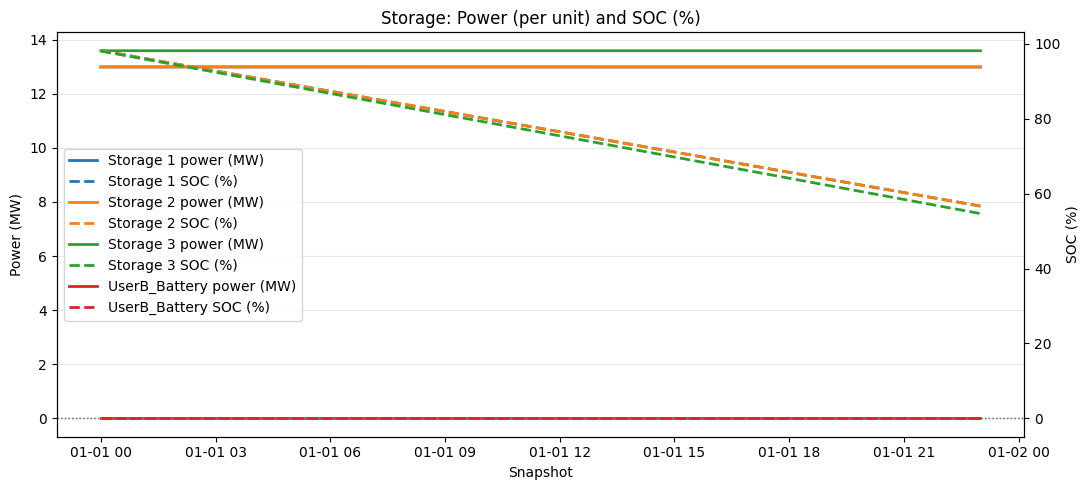

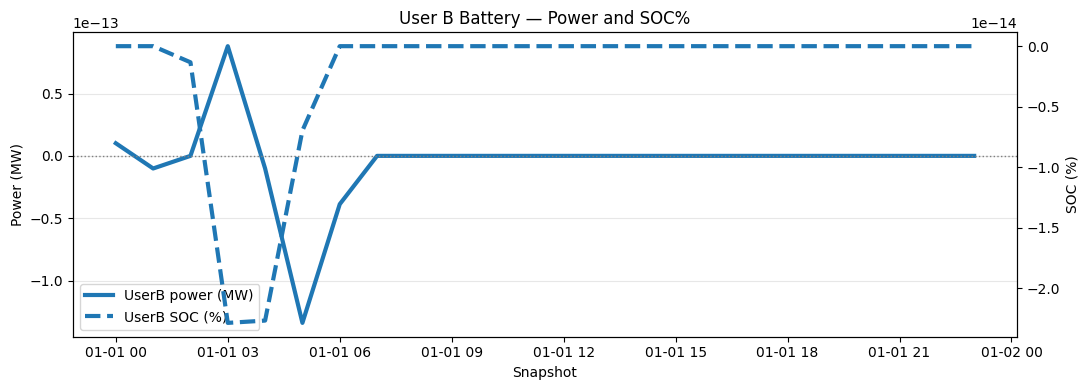

In [9]:

ps = n.storage_units_t.p

# Define SOC time series
soc = n.storage_units_t.state_of_charge

# Capacity per unit (MWh)
if "state_of_charge_nom" in n.storage_units.columns:
    cap = n.storage_units["state_of_charge_nom"]
else:  # fallback for older PyPSA
    cap = n.storage_units["p_nom"] * n.storage_units.get("max_hours", 1.0)

# Align columns (just in case)
units = n.storage_units.index
ps = ps.reindex(columns=units)
soc = soc.reindex(columns=units)
cap = cap.reindex(units)

# SOC % per unit
soc_pct_per_unit = soc.divide(cap, axis=1) * 100

# ---- Plot: per-unit power (left) and SOC% (right) with matching colors ----
fig, ax1 = plt.subplots(figsize=(11, 5))
ax2 = ax1.twinx()

# color cycle
from itertools import cycle
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

handles = []
labels = []

for unit, color in zip(units, colors):
    # Power (solid)
    h1 = ax1.plot(ps.index, ps[unit], label=f"{unit} power (MW)", color=color, linewidth=2)[0]
    # SOC% (dashed) with same color
    h2 = ax2.plot(soc_pct_per_unit.index, soc_pct_per_unit[unit],
                  label=f"{unit} SOC (%)", color=color, linestyle="--", linewidth=2)[0]
    handles += [h1, h2]
    labels  += [h1.get_label(), h2.get_label()]

ax1.axhline(0, linestyle=":", linewidth=1, color="gray")
ax1.set_title("Storage: Power (per unit) and SOC (%)")
ax1.set_xlabel("Snapshot")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("SOC (%)")

# Make axes a bit clearer
ax1.grid(True, which="both", axis="y", alpha=0.3)

# One combined legend
ax1.legend(handles, labels, loc="upper right", frameon=True)
plt.tight_layout()

ub = "UserB_Battery"  # convenience alias

# ↓↓↓ existing combined plot, just change the legend placement ↓↓↓
ax1.legend(handles, labels, loc="lower left", frameon=True)  # was "upper right"
plt.tight_layout()

# --- New: dedicated User B panel (power + SOC%) ---
if ub in units:
    fig, ax1b = plt.subplots(figsize=(11, 4))
    ax2b = ax1b.twinx()

    # Emphasize User B power (solid) and SOC% (dashed)
    h1b = ax1b.plot(ps.index, ps[ub], linewidth=3, label="UserB power (MW)")[0]
    h2b = ax2b.plot(soc_pct_per_unit.index, soc_pct_per_unit[ub],
                    linestyle="--", linewidth=3, label="UserB SOC (%)")[0]

    ax1b.axhline(0, linestyle=":", linewidth=1, color="gray")
    ax1b.set_title("User B Battery — Power and SOC%")
    ax1b.set_xlabel("Snapshot")
    ax1b.set_ylabel("Power (MW)")
    ax2b.set_ylabel("SOC (%)")
    ax1b.grid(True, which="both", axis="y", alpha=0.3)

    # Bottom-left legend for this panel too
    ax1b.legend([h1b, h2b], [h1b.get_label(), h2b.get_label()],
                loc="lower left", frameon=True)

    plt.tight_layout()
else:
    print("[Info] UserB_Battery not in n.storage_units.index; skipping dedicated panel.")

    # ... everything above stays the same ...

ax1.axhline(0, linestyle=":", linewidth=1, color="gray")
ax1.set_title("Storage: Power (per unit) and SOC (%)")
ax1.set_xlabel("Snapshot")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("SOC (%)")
ax1.grid(True, which="both", axis="y", alpha=0.3)

# One combined legend at mid-left (inside the axes)
ax1.legend(handles, labels, loc="center left", frameon=True)
plt.tight_layout()






### Cost Breakdown - Generator and Battery

In [10]:
w = n.snapshot_weightings["objective"].reindex(n.snapshots)  # hours in objective

# ---------------------------
# Generators (incl. UserA_PV)
# ---------------------------
# MW dispatch (T x G)
p_gen = n.generators_t.p.reindex(index=n.snapshots, columns=n.generators.index).fillna(0.0)

# Build hourly marginal_cost table (T x G): start from constants, overwrite with any time-varying
mc_gen_ts = pd.DataFrame(
    np.tile(n.generators["marginal_cost"].values, (len(n.snapshots), 1)),
    index=n.snapshots, columns=n.generators.index
)
if hasattr(n.generators_t, "marginal_cost") and not n.generators_t.marginal_cost.empty:
    # Overwrite the columns that exist in the time-varying table
    for col in n.generators_t.marginal_cost.columns.intersection(n.generators.index):
        mc_gen_ts[col] = n.generators_t.marginal_cost[col].reindex(n.snapshots).fillna(mc_gen_ts[col])

# Quadratic coefficients (G)
mc2_gen = n.generators.get(
    "marginal_cost_quadratic",
    pd.Series(0.0, index=n.generators.index)
).reindex(n.generators.index).fillna(0.0)

# Costs per snapshot (T x G), then sum over time → (G)
gen_cost_lin_ts  = (p_gen * mc_gen_ts).mul(w, axis=0)
gen_cost_quad_ts = ((p_gen ** 2) * mc2_gen).mul(w, axis=0)

gen_lin  = gen_cost_lin_ts.sum(axis=0)
gen_quad = gen_cost_quad_ts.sum(axis=0)
gen_opex = gen_lin + gen_quad

gen_breakdown = pd.DataFrame({
    "lin": gen_lin,
    "quad": gen_quad,
    "total": gen_opex
}).sort_values("total")

print("\n=== Manual OPEX — Generators (per asset) ===")
print(gen_breakdown)

# ---------------------------
# StorageUnits (incl. UserB_Battery) — discharge only
# ---------------------------
p_su = n.storage_units_t.p.reindex(index=n.snapshots, columns=n.storage_units.index).fillna(0.0)
p_su_pos = p_su.clip(lower=0.0)  # discharge MW only

# Hourly marginal_cost table (T x S)
mc_su_ts = pd.DataFrame(
    np.tile(n.storage_units["marginal_cost"].values, (len(n.snapshots), 1)),
    index=n.snapshots, columns=n.storage_units.index
)
if hasattr(n.storage_units_t, "marginal_cost") and not n.storage_units_t.marginal_cost.empty:
    for col in n.storage_units_t.marginal_cost.columns.intersection(n.storage_units.index):
        mc_su_ts[col] = n.storage_units_t.marginal_cost[col].reindex(n.snapshots).fillna(mc_su_ts[col])

# Quadratic coefficients (S)
mc2_su = n.storage_units.get(
    "marginal_cost_quadratic",
    pd.Series(0.0, index=n.storage_units.index)
).reindex(n.storage_units.index).fillna(0.0)

su_cost_lin_ts  = (p_su_pos * mc_su_ts).mul(w, axis=0)
su_cost_quad_ts = ((p_su_pos ** 2) * mc2_su).mul(w, axis=0)

su_lin  = su_cost_lin_ts.sum(axis=0)
su_quad = su_cost_quad_ts.sum(axis=0)
su_opex = su_lin + su_quad

su_breakdown = pd.DataFrame({
    "lin": su_lin,
    "quad": su_quad,
    "total": su_opex
}).sort_values("total")

print("\n=== Manual OPEX — StorageUnits (per asset, discharge-only costs) ===")
print(su_breakdown)

# ---------------------------
# Highlights for OPF-P2P users
# ---------------------------
ua, ub = "UserA_PV", "UserB_Battery"

if ua in gen_breakdown.index:
    r = gen_breakdown.loc[ua]
    print(f"\n[User A] OPEX — lin: {r['lin']:.6g}, quad: {r['quad']:.6g}, total: {r['total']:.6g}")

if ub in su_breakdown.index:
    r = su_breakdown.loc[ub]
    print(f"[User B] OPEX — lin: {r['lin']:.6g}, quad: {r['quad']:.6g}, total: {r['total']:.6g}")

# ---------------------------
# System totals
# ---------------------------
system_opex = gen_opex.sum() + su_opex.sum()
print(f"\n=== System OPEX total (Generators + StorageUnits): {system_opex:.6g} ===")


=== Manual OPEX — Generators (per asset) ===
                   lin        quad         total
name                                            
Gen 1    -6.847927e-12    0.000000 -6.847927e-12
Gen 2    -6.716232e-13    0.000000 -6.716232e-13
Gen 5    -4.844309e-13    0.000000 -4.844309e-13
Gen 4     2.836022e-11    0.000000  2.836022e-11
UserA_PV  5.836374e+01  624.493177  6.828569e+02
Gen 0     3.499199e+04    0.000000  3.499199e+04
Gen 3     9.040636e+04    0.000000  9.040636e+04

=== Manual OPEX — StorageUnits (per asset, discharge-only costs) ===
                        lin          quad         total
name                                                   
UserB_Battery  9.807195e-16  1.567429e-27  9.807195e-16
Storage 1      3.117794e+00  2.025134e+03  2.028252e+03
Storage 2      3.117795e+00  2.025134e+03  2.028252e+03
Storage 3      3.261791e+00  2.216516e+03  2.219778e+03

[User A] OPEX — lin: 58.3637, quad: 624.493, total: 682.857
[User B] OPEX — lin: 9.8072e-16, quad: 1.56743

### Unit Commitment of Generator

In [11]:
# ---------- Derive "unit commitment" (UC) from economic dispatch ----------

# Anything above a tiny threshold counts as ON
UC_THRESHOLD = 1e-3  # MW
UC = (pg > UC_THRESHOLD).astype(int)           # 1 = on, 0 = off
start_up  = ((UC == 1) & (UC.shift(fill_value=0) == 0)).astype(int)
shut_down = ((UC == 0) & (UC.shift(fill_value=0) == 1)).astype(int)

print("\n=== Derived UC (1=on, 0=off) ===")
print(UC)

print("\n=== Derived start-ups (1=start at this snapshot) ===")
print(start_up)

print("\n=== Derived shut-downs (1=stop at this snapshot) ===")
print(shut_down)

# ---------- Useful per‑generator summary ----------
def longest_on_streak(s: pd.Series) -> int:
    # longest consecutive run of 1s in a 0/1 series
    blocks = (s != s.shift()).cumsum()
    return s.groupby(blocks).sum().max()

summary = pd.DataFrame({
    "on_hours": UC.sum(),
    "starts": start_up.sum(),
    "shutdowns": shut_down.sum(),
    "max_consecutive_on": UC.apply(longest_on_streak),
    "avg_output_when_on_MW": pg.where(UC == 1).mean(),
    "capacity_MW": n.generators.p_nom
})
print("\n=== UC summary by generator ===")
print(summary.sort_index())


=== Derived UC (1=on, 0=off) ===
name                 Gen 0  Gen 1  Gen 2  Gen 3  Gen 4  Gen 5  UserA_PV
snapshot                                                               
2025-01-01 00:00:00      1      0      0      1      0      0         1
2025-01-01 01:00:00      1      0      0      1      0      0         1
2025-01-01 02:00:00      1      0      0      1      0      0         1
2025-01-01 03:00:00      1      0      0      1      0      0         1
2025-01-01 04:00:00      1      0      0      1      0      0         1
2025-01-01 05:00:00      1      0      0      1      0      0         1
2025-01-01 06:00:00      1      0      0      1      0      0         1
2025-01-01 07:00:00      1      0      0      1      0      0         1
2025-01-01 08:00:00      1      0      0      1      0      0         1
2025-01-01 09:00:00      1      0      0      1      0      0         1
2025-01-01 10:00:00      1      0      0      1      0      0         1
2025-01-01 11:00:00      1    

### Voltage Magnitude on Each Bus

In [12]:

# 1) Freeze OPF dispatch as PF setpoints
# -----------------------------
# Generators: use OPF P as p_set for PF
n.generators_t.p_set = n.generators_t.p.copy()

# 2) Include storage injections in PF
#    p > 0 = discharge (injection), p < 0 = charging (withdrawal)
# -----------------------------
_tmp_su_gens = []
for su in n.storage_units.index:
    tmpg = f"_SUinj_{su}"
    _tmp_su_gens.append(tmpg)
    bus = n.storage_units.at[su, "bus"]
    # Big enough nameplate so we don't bind
    n.add("Generator", tmpg, bus=bus, p_nom=1e6, control="PQ")
    # Ensure a p_set column exists then fill with the OPF dispatch
    if tmpg not in n.generators_t.p_set.columns:
        n.generators_t.p_set[tmpg] = 0.0
    n.generators_t.p_set[tmpg] = n.storage_units_t.p[su]

# 3) Choose bus types for PF

# -----------------------------
# Pick a slack generator (e.g., the cheapest Gen 5)

slack_gen = "Gen 5" if "Gen 5" in n.generators.index else n.generators.index[0]

n.generators["slack"] = False
n.generators.loc[:, "control"] = "PQ"
n.generators.at[slack_gen, "slack"] = True
n.generators.at[slack_gen, "control"] = "Slack"
n.generators.at[slack_gen, "v_set"] = 1.0   # pu at slack bus

# For completeness, set reactive setpoints for PQ gens to 0
n.generators_t.q_set = pd.DataFrame(
    0.0, index=n.snapshots, columns=n.generators.index
)

# -----------------------------
# 4) Run AC power flow across all snapshots
# -----------------------------
n.pf()   # Newton-Raphson PF over n.snapshots

# -----------------------------
# 5) Inspect voltages
# -----------------------------
print("\n=== Bus voltage magnitudes |V| (pu) ===")
print(n.buses_t.v_mag_pu)

# Quick health checks
vmin = n.buses_t.v_mag_pu.min(axis=1).rename("Vmin_pu")
vmax = n.buses_t.v_mag_pu.max(axis=1).rename("Vmax_pu")
print("\n=== Per-snapshot voltage envelope (min/max pu) ===")
print(pd.concat([vmin, vmax], axis=1))

# Example: flag snapshots violating +10% / -6% limits
viol = (vmin < 0.94) | (vmax > 1.10)
if viol.any():
    print("\nSnapshots with voltage violations (Vmin<0.94 or Vmax>1.10):")
    print(viol[viol].index.tolist())



INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x782f43007860> for snapshots DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00', '2025-01-01 05:00:00',
               '2025-01-01 06:00:00', '2025-01-01 07:00:00',
               '2025-01-01 08:00:00', '2025-01-01 09:00:00',
               '2025-01-01 10:00:00', '2025-01-01 11:00:00',
               '2025-01-01 12:00:00', '2025-01-01 13:00:00',
               '2025-01-01 14:00:00', '2025-01-01 15:00:00',
               '2025-01-01 16:00:00', '2025-01-01 17:00:00',
               '2025-01-01 18:00:00', '2025-01-01 19:00:00',
               '2025-01-01 20:00:00', '2025-01-01 21:00:00',
               '2025-01-01 22:00:00', '2025-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')



=== Bus voltage magnitudes |V| (pu) ===
name                    Bus 0     Bus 1     Bus 2     Bus 3  Bus 4  Bus 5  \
snapshot                                                                    
2025-01-01 00:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 01:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 02:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 03:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 04:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 05:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 06:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 07:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 08:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 09:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 10:00:00  1.000007  1.00

### Visualisation of Voltage Magnitude


Snapshots with any violation:
[]

Per-bus violation counts (descending):
name
Bus 0    0
Bus 1    0
Bus 2    0
Bus 3    0
Bus 4    0
Bus 5    0
Bus 6    0
Bus 7    0
dtype: int64


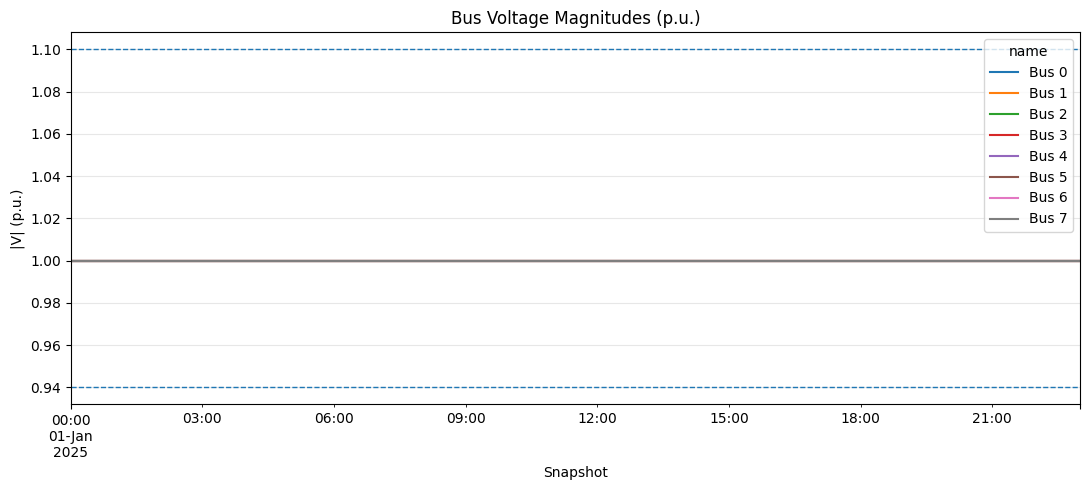

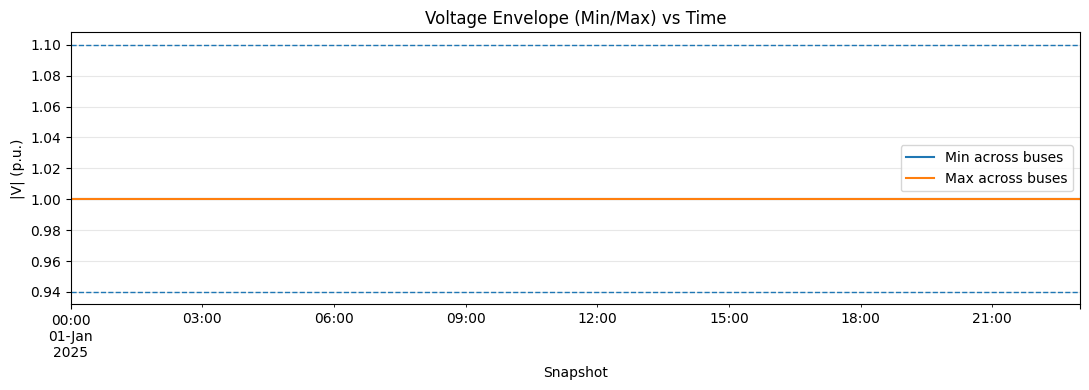

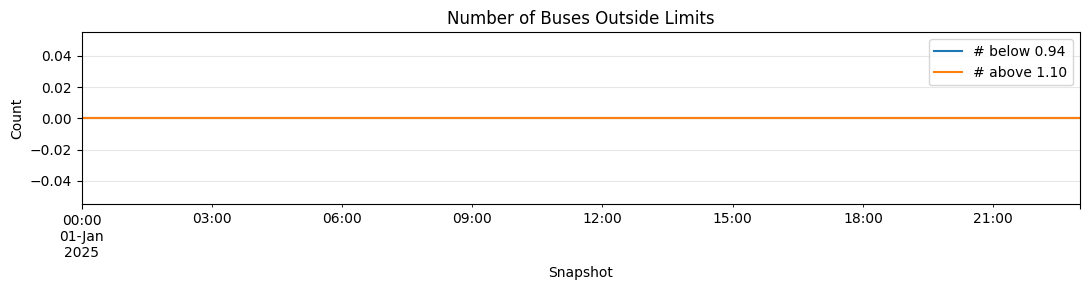

In [13]:
import matplotlib.pyplot as plt

V = n.buses_t.v_mag_pu.copy()           # |V| per bus over time (pu)
vmin = V.min(axis=1).rename("Vmin")
vmax = V.max(axis=1).rename("Vmax")

# -----------------------------
# 1) Per-bus voltage traces
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 5))
V.plot(ax=ax, legend=True)
ax.axhline(1.10, linestyle="--", linewidth=1)  # +10% line
ax.axhline(0.94, linestyle="--", linewidth=1)  # -6% line
ax.set_title("Bus Voltage Magnitudes (p.u.)")
ax.set_xlabel("Snapshot")
ax.set_ylabel("|V| (p.u.)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# 2) Voltage envelope (min/max across buses)
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 4))
vmin.plot(ax=ax, label="Min across buses")
vmax.plot(ax=ax, label="Max across buses")
ax.axhline(1.10, linestyle="--", linewidth=1)
ax.axhline(0.94, linestyle="--", linewidth=1)
ax.legend()
ax.set_title("Voltage Envelope (Min/Max) vs Time")
ax.set_xlabel("Snapshot")
ax.set_ylabel("|V| (p.u.)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# 3) Count how many buses violate limits at each snapshot
# -----------------------------
below = (V < 0.94).sum(axis=1).rename("# below 0.94")
above = (V > 1.10).sum(axis=1).rename("# above 1.10")

fig, ax = plt.subplots(figsize=(11, 3))
below.plot(ax=ax)
above.plot(ax=ax)
ax.legend()
ax.set_title("Number of Buses Outside Limits")
ax.set_xlabel("Snapshot")
ax.set_ylabel("Count")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# (Optional) quick text summaries
# -----------------------------
print("\nSnapshots with any violation:")
viol = (V.lt(0.94) | V.gt(1.10)).any(axis=1)
print(viol[viol].index.tolist())

print("\nPer-bus violation counts (descending):")
per_bus_viol = (V.lt(0.94) | V.gt(1.10)).sum().sort_values(ascending=False)
print(per_bus_viol)
